In [86]:
from collections import OrderedDict
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import LargeMultinomialLogitStep
from urbansim_templates.models import SmallMultinomialLogitStep
import orca
import os; os.chdir('../')
import warnings; warnings.simplefilter('ignore')

import pandas as pd
# import pandana as pdna
import time
import numpy as np
import matplotlib.pyplot as plt
import os
from functools import reduce

# import matplotlib
# matplotlib.style.use('ggplot')

%matplotlib inline

pd.options.display.max_columns = 80

In [88]:
import seaborn as sns
%matplotlib notebook

import glob

from scripts import datasources, models, variables

mm.initialize()

No yaml files found in path 'configs'


In [3]:
trips = pd.read_csv('/home/emma/ual_model_workspace/fall-2018-models/notebooks-emma/HWtrips_101418.csv')

trips.head()

,Unnamed: 0,HHPER,HHPERTRIP,origin,origin_dwell,origin_ST,origin_ET,trip_ET,TT,Ozone,Dzone,Oxcord,Oycord,Dxcord,Dycord,MODE
0,0,10352742,1.035274e+09,home,13.583333,19.166667,8.75,9.166667,0.416667,424.0,700.0,-122.017274,37.388281,-121.664242,37.151629,drive_alone
1,1,10352742,1.035274e+09,work,7.583333,9.166667,16.75,19.166667,2.416667,700.0,424.0,-121.664242,37.151629,-122.017274,37.388281,drive_alone
2,2,10414944,1.041494e+09,home,14.500000,18.000000,8.50,8.750000,0.250000,1095.0,1152.0,-122.091521,38.010760,-122.118103,37.885783,drive_alone
3,3,10414944,1.041494e+09,work,8.750000,8.750000,17.50,18.000000,0.500000,1152.0,1095.0,-122.118103,37.885783,-122.091521,38.010760,drive_alone
4,4,10417661,1.041766e+09,home,13.250000,18.750000,8.00,9.000000,1.000000,241.0,69.0,-122.414811,37.610585,-122.447100,37.779020,drive_alone


In [4]:
TOD_list = ['EA','AM','MD','PM','EV']
trips['TOD'] = (
    ((trips.origin_ET.between(3,6,inclusive = False)) | (trips.origin_ET==3))*1 +
    ((trips.origin_ET.between(6,9,inclusive = False)) | (trips.origin_ET==6))*2 +
    ((trips.origin_ET.between(9,15.5,inclusive = False)) | (trips.origin_ET==9))*3 +
    ((trips.origin_ET.between(15.5,18.5,inclusive = False)) | (trips.origin_ET==15.5))*4 +
    ((trips.origin_ET>=18.5))*5 +
    ((trips.origin_ET.between(0,3,inclusive = False)) | (trips.origin_ET==0))*5
)
TOD_dict = dict(zip(range(1,6),TOD_list))
trips['TOD'] = trips['TOD'].replace(TOD_dict)

TOD_dict = dict(zip(['EA', 'AM', 'MD', 'PM', 'EV'],range(1,6)))
trips['TOD'] = trips['TOD'].replace(TOD_dict)

trips['TOD'] = trips['TOD'] - 1

## Prepare table for model selecting HW and WH departure times at once

In [5]:
#select people who make both home-work and work-home trips:
tripsII = trips.groupby('HHPER').filter(lambda x: len(x) == 2)

In [6]:
#make sure all home-work trip rows are listed first
tripsIII = tripsII.sort_values(['HHPER','origin']).reset_index()

In [7]:
#move work-home trip info up into home-work trip rows

tripsIII['work_dwell'] = tripsIII.groupby('HHPER', group_keys=False).origin_dwell.shift(-1)
tripsIII['work_ST'] = tripsIII.groupby('HHPER', group_keys=False).origin_ST.shift(-1)
tripsIII['WH_trip_ST'] = tripsIII.groupby('HHPER', group_keys=False).origin_ET.shift(-1)
tripsIII['WH_trip_ET'] = tripsIII.groupby('HHPER', group_keys=False).trip_ET.shift(-1)
tripsIII['WH_TT'] = tripsIII.groupby('HHPER', group_keys=False).TT.shift(-1)
tripsIII['WH_mode'] = tripsIII.groupby('HHPER', group_keys=False).MODE.shift(-1)
tripsIII['WH_TOD'] = tripsIII.groupby('HHPER', group_keys=False).TOD.shift(-1)

In [8]:
tripsIII = tripsIII.groupby('HHPER').first().reset_index()

In [9]:
tripsIII.rename(columns = {'origin_dwell':'home_dwell','origin_ST':'home_ST','origin_ET':'HW_trip_ST',
                           'trip_ET':'HW_trip_ET','TT':'HW_TT','MODE':'HW_mode','TOD':'HW_TOD',
                          'Ozone':'Hzone','Dzone':'Wzone','Oxcord':'Hxcord','Oycord':'Hycord',
                          'Dxcord':'Wxcord','Dycord':'Wycord'},inplace = True)

tripsIII['TOD'] = tripsIII['HW_TOD'].map(str) + tripsIII['WH_TOD'].map(str)

tripsIII.head()

,HHPER,index,Unnamed: 0,HHPERTRIP,origin,home_dwell,home_ST,HW_trip_ST,HW_trip_ET,HW_TT,Hzone,Wzone,Hxcord,Hycord,Wxcord,Wycord,HW_mode,HW_TOD,work_dwell,work_ST,WH_trip_ST,WH_trip_ET,WH_TT,WH_mode,WH_TOD,TOD
0,10352742,0,0,1.035274e+09,home,13.583333,19.166667,8.750000,9.166667,0.416667,424.0,700.0,-122.017274,37.388281,-121.664242,37.151629,drive_alone,1,7.583333,9.166667,16.75,19.166667,2.416667,drive_alone,3.0,13.0
1,10414944,2,2,1.041494e+09,home,14.500000,18.000000,8.500000,8.750000,0.250000,1095.0,1152.0,-122.091521,38.010760,-122.118103,37.885783,drive_alone,1,8.750000,8.750000,17.50,18.000000,0.500000,drive_alone,3.0,13.0
2,10417661,4,4,1.041766e+09,home,13.250000,18.750000,8.000000,9.000000,1.000000,241.0,69.0,-122.414811,37.610585,-122.447100,37.779020,drive_alone,1,8.500000,9.000000,17.50,18.750000,1.250000,drive_alone,3.0,13.0
3,10417662,6,6,1.041766e+09,home,13.000000,19.000000,8.000000,8.500000,0.500000,241.0,282.0,-122.414811,37.610585,-122.328418,37.536798,drive_alone,1,10.000000,8.500000,18.50,19.000000,0.500000,drive_alone,4.0,14.0
4,10436132,8,8,1.043613e+09,home,11.866667,19.400000,7.266667,7.866667,0.600000,1004.0,1127.0,-122.252523,37.851942,-122.069993,37.969472,drive_alone,1,11.133333,7.866667,19.00,19.400000,0.400000,drive_alone,4.0,14.0


In [10]:
tripsIII['TOD'] = pd.to_numeric(tripsIII['TOD'])

## Add the demographic variables

In [11]:
person = pd.read_csv('/home/data/CHTS_csv_format/data/Deliv_PER.csv')

person.head()

,SAMPN,PERNO,RELAT,GEND,AGE,AGEB,HISP,RACE1,RACE2,RACE3,RACE4,O_RACE,NTVTY,CNTRY,LIC,USER,TRANS,TPTYP1,TPTYP2,TPTYP3,TPTYP4,TPTYP5,TPTYP6,TPTYP7,O_TPTYP,CLIP1,CLIP2,CLIP3,COMP,MET,PASSTL,FLEX,EMPLY,WKSTAT,O_WKSTAT,JOBS,WLOC,WNAME,WCITY,WSTAT,...,HVLOG,PTRIPS,TOLLF,TOLLR1,TOLLR2,TOLLR3,TOLLR4,TOLLR5,TOLLR6,TOLLR7,TOLLR8,TOLLR9,TOLLR10,TOLLB1,TOLLB2,TOLLB3,TOLLB4,TOLLB5,TOLLB6,TOLLB7,TOLLB8,TOLLB9,TOLLB10,HOVL,NOGOWHY,NOGOWHY_O,InComplete,Moto_trip,WCTFIP,WTRACT,SCTFIP,STRACT,WPrimaryCity,WSTFIP,W2PrimaryCity,W2STFIP,SPrimaryCity,SSTFIP,PERWGT,EXPPERWGT
0,1031985,1,1,1,74,NaN,2,1.0,NaN,NaN,NaN,NaN,1,NaN,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.052086,17.647568
1,1031985,2,2,2,73,NaN,2,1.0,NaN,NaN,NaN,NaN,1,NaN,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.052086,17.647568
2,1032036,1,1,1,46,NaN,2,1.0,NaN,NaN,NaN,NaN,1,NaN,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,1.0,NaN,NaN,1.0,1.0,HIDDEN,SAN DIEGO,CA,...,NaN,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,73.0,17032.0,NaN,NaN,SAN DIEGO,6.0,NaN,NaN,NaN,NaN,1.223974,414.701494
3,1032036,2,2,2,47,NaN,2,1.0,97.0,NaN,NaN,MULTI-RACIAL,1,NaN,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,18.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.863473,292.558373
4,1032036,3,3,1,15,NaN,2,1.0,97.0,NaN,NaN,MULTI-RACIAL,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,73.0,17030.0,NaN,NaN,NaN,NaN,SAN DIEGO,6.0,0.941412,318.965100


In [12]:
person = person[['SAMPN','PERNO','GEND','AGE','HISP','RACE1','RACE2','RACE3','RACE4','O_RACE','NTVTY','LIC','JOBS','HOURS','EDUCA','WSCHED','DISAB','INDUS','OCCUP']]

In [13]:
person['HHPER'] = person['SAMPN'].map(str) + person['PERNO'].map(str)

person['female'] = person['GEND'] - 1

person['HISP'] = np.where(person['HISP'] == 2, 0, person['HISP'])
person['white'] = np.where((person['RACE1'].isin([1.0]) | person['RACE2'].isin([1.0]) | person['RACE3'].isin([1.0]) | person['RACE4'].isin([1.0])),1,0)
person['black'] = np.where((person['RACE1'].isin([2.0]) | person['RACE2'].isin([2.0]) | person['RACE3'].isin([2.0]) | person['RACE4'].isin([2.0])),1,0)
person['native'] = np.where((person['RACE1'].isin([3.0]) | person['RACE2'].isin([3.0]) | person['RACE3'].isin([3.0]) | person['RACE4'].isin([3.0])),1,0)
person['asian'] = np.where((person['RACE1'].isin([4.0]) | person['RACE2'].isin([4.0]) | person['RACE3'].isin([4.0]) | person['RACE4'].isin([4.0])),1,0)
person['PI'] = np.where((person['RACE1'].isin([5.0]) | person['RACE2'].isin([5.0]) | person['RACE3'].isin([5.0]) | person['RACE4'].isin([5.0])),1,0)

person['immigrant'] = person['NTVTY'] - 1
person['nolic'] = person['LIC'] - 1

person['DISAB'] = np.where(person['DISAB'] == 2, 0, person['HISP'])

person.head()

,SAMPN,PERNO,GEND,AGE,HISP,RACE1,RACE2,RACE3,RACE4,O_RACE,NTVTY,LIC,JOBS,HOURS,EDUCA,WSCHED,DISAB,INDUS,OCCUP,HHPER,female,white,black,native,asian,PI,immigrant,nolic
0,1031985,1,1,74,0,1.0,NaN,NaN,NaN,NaN,1,1.0,NaN,NaN,6,NaN,0,NaN,NaN,10319851,0,1,0,0,0,0,0,0.0
1,1031985,2,2,73,0,1.0,NaN,NaN,NaN,NaN,1,1.0,NaN,NaN,6,NaN,0,NaN,NaN,10319852,1,1,0,0,0,0,0,0.0
2,1032036,1,1,46,0,1.0,NaN,NaN,NaN,NaN,1,1.0,1.0,40.0,6,2.0,0,54.0,15.0,10320361,0,1,0,0,0,0,0,0.0
3,1032036,2,2,47,0,1.0,97.0,NaN,NaN,MULTI-RACIAL,1,1.0,NaN,NaN,6,NaN,0,NaN,NaN,10320362,1,1,0,0,0,0,0,0.0
4,1032036,3,1,15,0,1.0,97.0,NaN,NaN,MULTI-RACIAL,1,NaN,NaN,NaN,1,NaN,0,NaN,NaN,10320363,0,1,0,0,0,0,0,NaN


In [14]:
hh_df = pd.read_csv('/home/data/CHTS_csv_format/data/Deliv_HH.csv')[
  ['SAMPN','HHVEH','HHBIC','OWN','INCOM','HHSIZ']]

hh_df['rent'] = hh_df['OWN'] - 1

hh_df.head()

,SAMPN,HHVEH,HHBIC,OWN,INCOM,HHSIZ,rent
0,1031985,2,2,1,3,2,0
1,1032036,1,4,1,7,5,0
2,1032053,2,2,2,2,6,1
3,1032425,2,3,1,7,2,0
4,1032558,0,0,2,1,1,1


In [15]:
demo = person.merge(hh_df,on = 'SAMPN',how = 'left')

demo.head()

,SAMPN,PERNO,GEND,AGE,HISP,RACE1,RACE2,RACE3,RACE4,O_RACE,NTVTY,LIC,JOBS,HOURS,EDUCA,WSCHED,DISAB,INDUS,OCCUP,HHPER,female,white,black,native,asian,PI,immigrant,nolic,HHVEH,HHBIC,OWN,INCOM,HHSIZ,rent
0,1031985,1,1,74,0,1.0,NaN,NaN,NaN,NaN,1,1.0,NaN,NaN,6,NaN,0,NaN,NaN,10319851,0,1,0,0,0,0,0,0.0,2,2,1,3,2,0
1,1031985,2,2,73,0,1.0,NaN,NaN,NaN,NaN,1,1.0,NaN,NaN,6,NaN,0,NaN,NaN,10319852,1,1,0,0,0,0,0,0.0,2,2,1,3,2,0
2,1032036,1,1,46,0,1.0,NaN,NaN,NaN,NaN,1,1.0,1.0,40.0,6,2.0,0,54.0,15.0,10320361,0,1,0,0,0,0,0,0.0,1,4,1,7,5,0
3,1032036,2,2,47,0,1.0,97.0,NaN,NaN,MULTI-RACIAL,1,1.0,NaN,NaN,6,NaN,0,NaN,NaN,10320362,1,1,0,0,0,0,0,0.0,1,4,1,7,5,0
4,1032036,3,1,15,0,1.0,97.0,NaN,NaN,MULTI-RACIAL,1,NaN,NaN,NaN,1,NaN,0,NaN,NaN,10320363,0,1,0,0,0,0,0,NaN,1,4,1,7,5,0


In [16]:
#drop RACE columns, gend, ntvty, lic, own
demo = demo.drop(columns=['GEND','RACE1','RACE2','RACE3','RACE4','O_RACE','NTVTY','LIC','OWN'])

In [17]:
na_dict = {
    'female':[8],
    'AGE':[998,999],
#     'RACE':[97,98,99],
    'immigrant':[7,8],
    'nolic':[7,8],
    'JOBS':[98,99],
    'HOURS':[998,999],
    'EDUCA':[8,9],
    'WSCHED':[8,9],
    'DISAB':[8,9],
    'HHVEH':[98,99],
    'HHBIC':[98,99],
#     'VEHNEW':[8,9],
    'rent':[6,7,8],
    'INCOM':[98,99],
    'HHSIZ':[98,99],
    'INDUS':[98,99],
    'OCCUP':[98,99]
}

for col in na_dict:
    for vals in na_dict[col]:
        demo[col] = demo[col].replace(vals,np.nan)
        
# demo.dropna(inplace = True)

In [18]:
demo.isnull().sum(axis = 0)

SAMPN            0
PERNO            0
AGE           3924
HISP             0
JOBS         57427
HOURS        59603
EDUCA         2088
WSCHED       58106
DISAB          141
INDUS        58467
OCCUP        58897
HHPER            0
female         311
white            0
black            0
native           0
asian            0
PI               0
immigrant      325
nolic        19666
HHVEH            0
HHBIC          148
INCOM         8839
HHSIZ            0
rent           339
dtype: int64

In [19]:
demo1 = demo.copy()

demo1.dropna(inplace = True)

In [20]:
print (len(person.index))
print (len(hh_df.index))
print (len(demo.index))
print (len(demo1.index))

109113
42431
109113
42881


In [21]:
tripsIII['HHPER'] = tripsIII['HHPER'].map(str)

trips0 = pd.merge(tripsIII, demo, on='HHPER')

trips1 = pd.merge(tripsIII, demo1, on='HHPER')

print (len(tripsIII.index))
print (len(trips0.index))
print (len(trips1.index))

5733
5733
4836


In [22]:
tripsIII.isnull().sum(axis = 0)

HHPER          0
index          0
Unnamed: 0     0
HHPERTRIP      0
origin         0
home_dwell     0
home_ST        0
HW_trip_ST     0
HW_trip_ET     0
HW_TT          0
Hzone          0
Wzone          0
Hxcord         0
Hycord         0
Wxcord         0
Wycord         0
HW_mode        0
HW_TOD         0
work_dwell     0
work_ST        0
WH_trip_ST     0
WH_trip_ET    59
WH_TT         59
WH_mode        0
WH_TOD         0
TOD            0
dtype: int64

In [23]:
trips0.isnull().sum(axis = 0)

HHPER           0
index           0
Unnamed: 0      0
HHPERTRIP       0
origin          0
home_dwell      0
home_ST         0
HW_trip_ST      0
HW_trip_ET      0
HW_TT           0
Hzone           0
Wzone           0
Hxcord          0
Hycord          0
Wxcord          0
Wycord          0
HW_mode         0
HW_TOD          0
work_dwell      0
work_ST         0
WH_trip_ST      0
WH_trip_ET     59
WH_TT          59
WH_mode         0
WH_TOD          0
TOD             0
SAMPN           0
PERNO           0
AGE           245
HISP            0
JOBS           12
HOURS         136
EDUCA          77
WSCHED         58
DISAB           3
INDUS         127
OCCUP         150
female         16
white           0
black           0
native          0
asian           0
PI              0
immigrant      12
nolic           2
HHVEH           0
HHBIC           4
INCOM         468
HHSIZ           0
rent            9
dtype: int64

In [24]:
x = trips0.loc[(trips0['INDUS'].isnull()) & (trips0['OCCUP'].isnull())]

len(x.index)

93

In [25]:
trips = trips1

In [26]:
trips1['less10k'] = np.where(trips1['INCOM'].isin([1.0]),1,0)
trips1['10kless25k'] = np.where(trips1['INCOM'].isin([2.0]),1,0)
trips1['25kless35k'] = np.where(trips1['INCOM'].isin([3.0]),1,0)
trips1['35kless50k'] = np.where(trips1['INCOM'].isin([4.0]),1,0)
trips1['50kless75k'] = np.where(trips1['INCOM'].isin([5.0]),1,0)
trips1['75kless100k'] = np.where(trips1['INCOM'].isin([6.0]),1,0)
trips1['100kless150k'] = np.where(trips1['INCOM'].isin([7.0]),1,0)
trips1['150kless200k'] = np.where(trips1['INCOM'].isin([8.0]),1,0)
trips1['200kless250k'] = np.where(trips1['INCOM'].isin([9.0]),1,0)
trips1['250kplus'] = np.where(trips1['INCOM'].isin([10.0]),1,0)
trips1['150kplus'] = np.where(trips1['INCOM'].isin([8.0,9.0,10.0]),1,0)

In [27]:
trips1['lessGED'] = np.where(trips1['EDUCA'].isin([1.0]),1,0)
trips1['GED'] = np.where(trips1['EDUCA'].isin([2.0]),1,0)
trips1['someBach'] = np.where(trips1['EDUCA'].isin([3.0]),1,0)
trips1['Assoc'] = np.where(trips1['EDUCA'].isin([4.0]),1,0)
trips1['Bach'] = np.where(trips1['EDUCA'].isin([5.0]),1,0)
trips1['Grad'] = np.where(trips1['EDUCA'].isin([6.0]),1,0)

In [28]:
trips1['minority'] = np.where(trips1['white'] == 1, 0, 1)

trips1.rename(columns = {'WSCHED':'flexsched'},inplace = True)

In [ ]:
# trips1[['AGE', 'JOBS', 'HOURS', 'HHVEH', 'HHBIC', 'HHSIZ']].describe()

In [29]:
trips1['16less25'] = np.where(((trips1.AGE.between(16,25,inclusive = False)) | (trips1.AGE==16)),1,0)
trips1['25less40'] = np.where(((trips1.AGE.between(25,40,inclusive = False)) | (trips1.AGE==25)),1,0)
trips1['40less50'] = np.where(((trips1.AGE.between(40,50,inclusive = False)) | (trips1.AGE==40)),1,0)
trips1['50less60'] = np.where(((trips1.AGE.between(50,60,inclusive = False)) | (trips1.AGE==50)),1,0)
trips1['60less85'] = np.where(((trips1.AGE.between(60,85,inclusive = False)) | (trips1.AGE==60)),1,0)

In [30]:
trips1['1job'] = np.where(trips1.JOBS.isin([1.0]),1,0)
trips1['2plusjobs'] = np.where(trips1.JOBS.between(2,5,inclusive = True),1,0)

trips1['35hoursorless'] = np.where(trips1.HOURS.between(1,35,inclusive = True),1,0)
trips1['35to45hours'] = np.where(((trips1.HOURS.between(35,45,inclusive = False)) | (trips1.HOURS==45)),1,0)
trips1['over45hours'] = np.where(((trips1.HOURS.between(45,90,inclusive = False)) | (trips1.HOURS==90)),1,0)

In [31]:
trips1['noveh'] = np.where(trips1.HHVEH.isin([0.0]),1,0)
trips1['1veh'] = np.where(trips1.HHVEH.isin([1.0]),1,0)
trips1['2veh'] = np.where(trips1.HHVEH.isin([2.0]),1,0)
trips1['3plusveh'] = np.where(trips1.HHVEH.between(3,8,inclusive = True),1,0)

trips1['nobic'] = np.where(trips1.HHBIC.isin([0.0]),1,0)
# trips1['1'] = np.where(trips1.HHVEH.isin([1.0]),1,0)
# trips1['2veh'] = np.where(trips1.HHVEH.isin([2.0]),1,0)
# trips1['3plusveh'] = np.where(trips1.HHVEH.between(3,8,inclusive = True),1,0)

trips1['1per'] = np.where(trips1.HHSIZ.isin([1.0]),1,0)
trips1['2per'] = np.where(trips1.HHSIZ.isin([2.0]),1,0)
trips1['3per'] = np.where(trips1.HHSIZ.isin([3.0]),1,0)
trips1['4plusper'] = np.where(trips1.HHSIZ.between(4,8,inclusive = True),1,0)

In [32]:
### make indus and occup dummies ###

trips1 = trips

trips['manager'] = np.where(trips['OCCUP'].isin([11]),1,0)
trips['business_finance'] = np.where(trips['OCCUP'].isin([13]),1,0)
trips['computer_math'] = np.where(trips['OCCUP'].isin([15]),1,0)
trips['arch_eng'] = np.where(trips['OCCUP'].isin([17]),1,0)
trips['scientist'] = np.where(trips['OCCUP'].isin([19]),1,0)
trips['socialservice'] = np.where(trips['OCCUP'].isin([21]),1,0)
trips['legal'] = np.where(trips['OCCUP'].isin([23]),1,0)
trips['teacher'] = np.where(trips['OCCUP'].isin([25]),1,0)
trips['arts_entertain'] = np.where(trips['OCCUP'].isin([27]),1,0)
trips['healthcare_practitioner'] = np.where(trips['OCCUP'].isin([29]),1,0)
trips['healthcare_support'] = np.where(trips['OCCUP'].isin([31]),1,0)
trips['protectiveservice'] = np.where(trips['OCCUP'].isin([33]),1,0)
trips['foodprep'] = np.where(trips['OCCUP'].isin([35]),1,0)
trips['cleaning_maintenance'] = np.where(trips['OCCUP'].isin([37]),1,0)
trips['personalcare'] = np.where(trips['OCCUP'].isin([39]),1,0)
trips['sales'] = np.where(trips['OCCUP'].isin([41]),1,0)
trips['office_admin'] = np.where(trips['OCCUP'].isin([43]),1,0)
trips['farmer'] = np.where(trips['OCCUP'].isin([45]),1,0)
trips['construction_extraction'] = np.where(trips['OCCUP'].isin([47]),1,0)
trips['installation_mechanic'] = np.where(trips['OCCUP'].isin([49]),1,0)
trips['production'] = np.where(trips['OCCUP'].isin([51]),1,0)
trips['transporter'] = np.where(trips['OCCUP'].isin([53]),1,0)
trips['military'] = np.where(trips['OCCUP'].isin([55]),1,0)
trips['other'] = np.where(trips['OCCUP'].isin([97]),1,0)

trips['agri'] = np.where(trips['INDUS'].isin([11]),1,0)
trips['mining'] = np.where(trips['INDUS'].isin([21]),1,0)
trips['utility'] = np.where(trips['INDUS'].isin([22]),1,0)
trips['construction'] = np.where(trips['INDUS'].isin([23]),1,0)
trips['manufacturing'] = np.where(trips['INDUS'].isin([31]),1,0)
trips['trade'] = np.where(trips['INDUS'].isin([42,44]),1,0)
trips['transport'] = np.where(trips['INDUS'].isin([48]),1,0)
trips['info'] = np.where(trips['INDUS'].isin([51]),1,0)
trips['finance'] = np.where(trips['INDUS'].isin([52]),1,0)
trips['realestate'] = np.where(trips['INDUS'].isin([53]),1,0)
trips['scitech'] = np.where(trips['INDUS'].isin([54]),1,0)
trips['manage'] = np.where(trips['INDUS'].isin([55]),1,0)
trips['admin'] = np.where(trips['INDUS'].isin([56]),1,0)
trips['educ'] = np.where(trips['INDUS'].isin([61]),1,0)
trips['health'] = np.where(trips['INDUS'].isin([62]),1,0)
trips['artsrec'] = np.where(trips['INDUS'].isin([71]),1,0)
trips['hospitality'] = np.where(trips['INDUS'].isin([72]),1,0)
trips['services'] = np.where(trips['INDUS'].isin([81]),1,0)
trips['gov'] = np.where(trips['INDUS'].isin([92]),1,0)
trips['other'] = np.where(trips['INDUS'].isin([97]),1,0)

trips1 = trips

## Creating the skims table

### still haven't added walk and bike distances and times (might differ by direction even if not by time)

In [33]:
# skim_dir = '/home/data/fall_2018/mtc_skims'
# distance_EA = pd.read_csv(skim_dir + f'/DistanceSkimsDatabaseEA.csv').replace(-999, 9999)
# distance_AM = pd.read_csv(skim_dir + f'/DistanceSkimsDatabaseAM.csv').replace(-999, 9999)
# distance_MD = pd.read_csv(skim_dir + f'/DistanceSkimsDatabaseMD.csv').replace(-999, 9999)
# distance_PM = pd.read_csv(skim_dir + f'/DistanceSkimsDatabasePM.csv').replace(-999, 9999)
# distance_EV = pd.read_csv(skim_dir + f'/DistanceSkimsDatabaseEV.csv').replace(-999, 9999)

# cost_EA = pd.read_csv(skim_dir + f'/CostSkimsDatabaseEA.csv').replace(-999, 9999)
# cost_AM = pd.read_csv(skim_dir + f'/CostSkimsDatabaseAM.csv').replace(-999, 9999)
# cost_MD = pd.read_csv(skim_dir + f'/CostSkimsDatabaseMD.csv').replace(-999, 9999)
# cost_PM = pd.read_csv(skim_dir + f'/CostSkimsDatabasePM.csv').replace(-999, 9999)
# cost_EV = pd.read_csv(skim_dir + f'/CostSkimsDatabaseEV.csv').replace(-999, 9999)

# Time_EA = pd.read_csv(skim_dir + f'/TimeSkimsDatabaseEA.csv').replace(-999, 9999)
# Time_AM = pd.read_csv(skim_dir + f'/TimeSkimsDatabaseAM.csv').replace(-999, 9999)
# Time_MD = pd.read_csv(skim_dir + f'/TimeSkimsDatabaseMD.csv').replace(-999, 9999)
# Time_PM = pd.read_csv(skim_dir + f'/TimeSkimsDatabasePM.csv').replace(-999, 9999)
# Time_EV = pd.read_csv(skim_dir + f'/TimeSkimsDatabaseEV.csv').replace(-999, 9999)

In [ ]:
# distance_EA = distance_EA.rename(
#         columns = dict(zip([i for i in distance_EA.columns if i not in ['orig','dest']],
#          [i+ f'_distance_EA' for i in distance_EA.columns if i not in ['orig','dest']])))

In [ ]:
# distance_AM = distance_AM.rename(
#         columns = dict(zip([i for i in distance_AM.columns if i not in ['orig','dest']],
#          [i+ f'_distance_AM' for i in distance_AM.columns if i not in ['orig','dest']])))

In [63]:
# distance_MD = distance_MD.rename(
#         columns = dict(zip([i for i in distance_MD.columns if i not in ['orig','dest']],
#          [i+ f'_distance_MD' for i in distance_MD.columns if i not in ['orig','dest']])))

In [64]:
# distance_PM = distance_PM.rename(
#         columns = dict(zip([i for i in distance_PM.columns if i not in ['orig','dest']],
#          [i+ f'_distance_PM' for i in distance_PM.columns if i not in ['orig','dest']])))

In [65]:
# distance_EV = distance_EV.rename(
#         columns = dict(zip([i for i in distance_EV.columns if i not in ['orig','dest']],
#          [i+ f'_distance_EV' for i in distance_EV.columns if i not in ['orig','dest']])))

In [66]:
# cost_EA = cost_EA.rename(
#         columns = dict(zip([i for i in cost_EA.columns if i not in ['orig','dest']],
#          [i+ f'_cost_EA' for i in cost_EA.columns if i not in ['orig','dest']])))

In [67]:
# cost_AM=cost_AM.rename(
#         columns = dict(zip([i for i in cost_AM.columns if i not in ['orig','dest']],
#          [i+ f'_cost_AM' for i in cost_AM.columns if i not in ['orig','dest']])))

In [68]:
# cost_MD=cost_MD.rename(
#         columns = dict(zip([i for i in cost_MD.columns if i not in ['orig','dest']],
#          [i+ f'_cost_MD' for i in cost_MD.columns if i not in ['orig','dest']])))

In [69]:
# cost_PM= cost_PM.rename(
#         columns = dict(zip([i for i in cost_PM.columns if i not in ['orig','dest']],
#          [i+ f'_cost_PM' for i in cost_PM.columns if i not in ['orig','dest']])))

In [ ]:
# cost_EV=cost_EV.rename(
#         columns = dict(zip([i for i in cost_EV.columns if i not in ['orig','dest']],
#          [i+ f'_cost_EV' for i in cost_EV.columns if i not in ['orig','dest']])))

In [ ]:
# Time_EA=Time_EA.rename(
#         columns = dict(zip([i for i in Time_EA.columns if i not in ['orig','dest']],
#          [i+ f'_Time_EA' for i in Time_EA.columns if i not in ['orig','dest']])))

In [ ]:
# Time_AM=Time_AM.rename(
#         columns = dict(zip([i for i in Time_AM.columns if i not in ['orig','dest']],
#          [i+ f'_Time_AM' for i in Time_AM.columns if i not in ['orig','dest']])))

In [ ]:
# Time_MD=Time_MD.rename(
#         columns = dict(zip([i for i in Time_MD.columns if i not in ['orig','dest']],
#          [i+ f'_Time_MD' for i in Time_MD.columns if i not in ['orig','dest']])))

In [ ]:
# Time_PM=Time_PM.rename(
#         columns = dict(zip([i for i in Time_PM.columns if i not in ['orig','dest']],
#          [i+ f'_Time_PM' for i in Time_PM.columns if i not in ['orig','dest']])))

In [75]:
# Time_EV=Time_EV.rename(
#         columns = dict(zip([i for i in Time_EV.columns if i not in ['orig','dest']],
#          [i+ f'_Time_EV' for i in Time_EV.columns if i not in ['orig','dest']])))

In [ ]:
# data_frames = [distance_EA,distance_AM,distance_MD,distance_PM,distance_EV,
#               cost_EA,cost_AM,cost_MD,cost_PM,cost_EV,
#               Time_EA,Time_AM,Time_MD,Time_PM,Time_EV]
# skims = reduce(lambda  left,right: pd.merge(left,right,on=['orig','dest'],
#                                             how='outer'), data_frames)

In [ ]:
# skims.head()

In [ ]:
# skims.to_csv('skims_110118.csv')

In [35]:
# skims = pd.read_csv('/home/emma/ual_model_workspace/fall-2018-models/skims_110118.csv')

In [80]:
# zones = trips1[['HHPER','Hzone','Wzone']]

In [81]:
# skims1 = pd.merge(zones, skims, how = 'left', left_on=['Hzone','Wzone'], right_on=['orig','dest'])

In [82]:
# skims2 = pd.merge(skims1, skims, how = 'left', left_on=['Wzone','Hzone'], right_on=['orig','dest'], suffixes=('_HW', '_WH'))

In [83]:
# skims3 = skims2.copy()
# TOD_list = ['EA','AM','MD','PM','EV']
# var_list = ['distance','cost','Time']
# mode_list_1 = ['da','daToll','s2','s2Toll','s3','s3Toll','walk','bike']
# # mode_list_1 = ['da','daToll','s2','s2Toll']
# mode_list_2 = ['da','daToll','s2','s2Toll','s3','s3Toll','wTrnW']
# # mode_list_2 = ['da','daToll','s2','s2Toll','wTrnW','dTrnW','wTrnD']
# mode_list_3 = ['da','daToll','s2','s2Toll','s3','s3Toll','walk','bike','wTrnW']

# for mode in mode_list_1:
# #     for variable in var_list:

#         for tod1 in TOD_list:
#             for tod2 in TOD_list:
#                 col_name = f'{mode}_distance_{tod1}_{tod2}'
#                 skims3[col_name] = skims3[f'{mode}_distance_{tod1}_HW'] + skims3[f'{mode}_distance_{tod2}_WH']

In [84]:
# for mode in mode_list_2:
# #     for variable in var_list:

#         for tod1 in TOD_list:
#             for tod2 in TOD_list:
#                 col_name = f'{mode}_cost_{tod1}_{tod2}'
#                 skims3[col_name] = skims3[f'{mode}_cost_{tod1}_HW'] + skims3[f'{mode}_cost_{tod2}_WH']

In [85]:
# for mode in mode_list_3:
# #     for variable in var_list:

#         for tod1 in TOD_list:
#             for tod2 in TOD_list:
#                 col_name = f'{mode}_Time_{tod1}_{tod2}'
#                 skims3[col_name] = skims3[f'{mode}_Time_{tod1}_HW'] + skims3[f'{mode}_Time_{tod2}_WH']

In [86]:
# var_list2 = ['cost','Time']
# for variable in var_list2:
#     for tod1 in TOD_list:
#         for tod2 in TOD_list:
#                 col_name = f'dTrnW_{variable}_{tod1}_{tod2}'
#                 skims3[col_name] = skims3[f'dTrnW_{variable}_{tod1}_HW'] + skims3[f'wTrnD_{variable}_{tod2}_WH']

In [87]:
# skims3.drop(skims3.filter(regex='_HW').columns, axis = 1, inplace = True)

# skims3.drop(skims3.filter(regex='_WH').columns, axis = 1, inplace = True)

In [88]:
# skims3.head()

,HHPER,Hzone,Wzone,da_distance_EA_EA,da_distance_EA_AM,da_distance_EA_MD,da_distance_EA_PM,da_distance_EA_EV,da_distance_AM_EA,da_distance_AM_AM,da_distance_AM_MD,da_distance_AM_PM,da_distance_AM_EV,da_distance_MD_EA,da_distance_MD_AM,da_distance_MD_MD,da_distance_MD_PM,da_distance_MD_EV,da_distance_PM_EA,da_distance_PM_AM,da_distance_PM_MD,da_distance_PM_PM,da_distance_PM_EV,da_distance_EV_EA,da_distance_EV_AM,da_distance_EV_MD,da_distance_EV_PM,da_distance_EV_EV,daToll_distance_EA_EA,daToll_distance_EA_AM,daToll_distance_EA_MD,daToll_distance_EA_PM,daToll_distance_EA_EV,daToll_distance_AM_EA,daToll_distance_AM_AM,daToll_distance_AM_MD,daToll_distance_AM_PM,daToll_distance_AM_EV,daToll_distance_MD_EA,daToll_distance_MD_AM,...,dTrnW_cost_MD_EA,dTrnW_cost_MD_AM,dTrnW_cost_MD_MD,dTrnW_cost_MD_PM,dTrnW_cost_MD_EV,dTrnW_cost_PM_EA,dTrnW_cost_PM_AM,dTrnW_cost_PM_MD,dTrnW_cost_PM_PM,dTrnW_cost_PM_EV,dTrnW_cost_EV_EA,dTrnW_cost_EV_AM,dTrnW_cost_EV_MD,dTrnW_cost_EV_PM,dTrnW_cost_EV_EV,dTrnW_Time_EA_EA,dTrnW_Time_EA_AM,dTrnW_Time_EA_MD,dTrnW_Time_EA_PM,dTrnW_Time_EA_EV,dTrnW_Time_AM_EA,dTrnW_Time_AM_AM,dTrnW_Time_AM_MD,dTrnW_Time_AM_PM,dTrnW_Time_AM_EV,dTrnW_Time_MD_EA,dTrnW_Time_MD_AM,dTrnW_Time_MD_MD,dTrnW_Time_MD_PM,dTrnW_Time_MD_EV,dTrnW_Time_PM_EA,dTrnW_Time_PM_AM,dTrnW_Time_PM_MD,dTrnW_Time_PM_PM,dTrnW_Time_PM_EV,dTrnW_Time_EV_EA,dTrnW_Time_EV_AM,dTrnW_Time_EV_MD,dTrnW_Time_EV_PM,dTrnW_Time_EV_EV
0,10414944,1095,1152,27.95,27.95,27.95,27.95,27.95,26.38,26.38,26.38,26.38,26.38,27.95,27.95,27.95,27.95,27.95,27.95,27.95,27.95,27.95,27.95,27.95,27.95,27.95,27.95,27.95,27.95,27.95,27.95,27.95,27.95,26.38,26.38,26.38,26.38,26.38,27.95,27.95,...,282.0,282.0,282.0,282.0,282.0,282.0,282.0,282.0,282.0,282.0,282.0,282.0,282.0,282.0,282.0,96.06,94.77,96.24,95.98,98.59,93.18,91.89,93.36,93.10,95.71,96.24,94.95,96.42,96.16,98.77,95.98,94.69,96.16,95.90,98.51,98.59,97.30,98.77,98.51,101.12
1,10417661,241,69,30.92,30.27,30.27,30.27,30.92,30.92,30.27,30.27,30.27,30.92,30.92,30.27,30.27,30.27,30.92,30.92,30.27,30.27,30.27,30.92,30.92,30.27,30.27,30.27,30.92,30.92,30.27,30.27,30.27,30.92,30.92,30.27,30.27,30.27,30.92,30.92,30.27,...,880.0,880.0,832.0,880.0,880.0,928.0,928.0,880.0,928.0,928.0,928.0,928.0,880.0,928.0,928.0,134.55,129.62,130.44,128.65,135.75,129.17,124.24,125.06,123.27,130.37,126.83,121.90,122.72,120.93,128.03,125.33,120.40,121.22,119.43,126.53,132.62,127.69,128.51,126.72,133.82
2,10417662,241,282,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,...,563.0,804.0,804.0,804.0,804.0,563.0,804.0,804.0,804.0,804.0,563.0,804.0,804.0,804.0,804.0,182.87,156.04,155.30,156.01,183.93,155.54,128.71,127.97,128.68,156.60,153.95,127.12,126.38,127.09,155.01,152.77,125.94,125.20,125.91,153.83,178.16,151.33,150.59,151.30,179.22
3,10436132,1004,1127,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,...,10328.0,739.0,739.0,739.0,10328.0,10328.0,739.0,739.0,739.0,10328.0,19998.0,10409.0,10409.0,10409.0,19998.0,19998.00,10085.15,10089.02,10088.27,19998.00,10087.52,174.67,178.54,177.79,10087.52,10089.01,176.16,180.03,179.28,10089.01,10088.24,175.39,179.26,178.51,10088.24,19998.00,10085.15,10089.02,10088.27,19998.00
4,10456071,908,116,31.94,34.03,31.94,34.03,31.94,33.77,35.86,33.77,35.86,33.77,31.94,34.03,31.94,34.03,31.94,33.77,35.86,33.77,35.86,33.77,31.94,34.03,31.94,34.03,31.94,31.94,34.03,31.94,34.03,31.94,33.77,35.86,33.77,35.86,33.77,31.94,34.03,...,586.0,586.0,586.0,586.0,586.0,586.0,586.0,586.0,586.0,586.0,586.0,586.0,586.0,586.0,586.0,104.66,102.11,102.07,102.14,108.25,102.11,99.56,99.52,99.59,105.70,102.07,99.52,99.48,99.55,105.66,102.14,99.59,99.55,99.62,105.73,108.25,105.70,105.66,105.73,111.84


In [89]:
# len(skims3.index)

4836

In [92]:
# skims3.to_csv('/home/emma/ual_model_workspace/fall-2018-models/skims3correct_110518.csv')

In [34]:
skims3 = pd.read_csv('/home/emma/ual_model_workspace/fall-2018-models/skims3correct_110518.csv')

In [ ]:
skims3.rename(columns = {'bike_15_EA_home':'bike_15_home','bike_30_EA_home':'bike_30_home','bike_45_EA_home':'bike_45_home',
                       'bike_15_EA_work':'bike_15_work','bike_30_EA_work':'bike_30_work','bike_45_EA_work':'bike_45_work',
                       'walk_15_EA_home':'walk_15_home','walk_30_EA_home':'walk_30_home','walk_45_EA_home':'walk_45_home',
                       'walk_15_EA_work':'walk_15_work','walk_30_EA_work':'walk_30_work','walk_45_EA_work':'walk_45_work',},inplace = True)

In [35]:
trips1 = trips1.convert_objects(convert_numeric=True)

In [36]:
trips1 = pd.merge(trips1, skims3, how = 'left', on= ['HHPER'])

In [37]:
trips1.TOD.value_counts()

13.0    2346
12.0     573
23.0     420
14.0     404
24.0     377
2.0      201
3.0      196
22.0     164
34.0      73
4.0       23
41.0      18
11.0      15
44.0       9
1.0        6
33.0       4
42.0       3
30.0       1
0.0        1
21.0       1
31.0       1
Name: TOD, dtype: int64

In [38]:
trips = trips1.loc[trips1['TOD'].isin([2,3,12,13,14,22,23,24])]

In [39]:
trips.head()

,HHPER,index,Unnamed: 0_x,HHPERTRIP,origin,home_dwell,home_ST,HW_trip_ST,HW_trip_ET,HW_TT,Hzone_x,Wzone_x,Hxcord,Hycord,Wxcord,Wycord,HW_mode,HW_TOD,work_dwell,work_ST,WH_trip_ST,WH_trip_ET,WH_TT,WH_mode,WH_TOD,TOD,SAMPN,PERNO,AGE,HISP,JOBS,HOURS,EDUCA,flexsched,DISAB,INDUS,OCCUP,female,white,black,...,dTrnW_cost_MD_EA,dTrnW_cost_MD_AM,dTrnW_cost_MD_MD,dTrnW_cost_MD_PM,dTrnW_cost_MD_EV,dTrnW_cost_PM_EA,dTrnW_cost_PM_AM,dTrnW_cost_PM_MD,dTrnW_cost_PM_PM,dTrnW_cost_PM_EV,dTrnW_cost_EV_EA,dTrnW_cost_EV_AM,dTrnW_cost_EV_MD,dTrnW_cost_EV_PM,dTrnW_cost_EV_EV,dTrnW_Time_EA_EA,dTrnW_Time_EA_AM,dTrnW_Time_EA_MD,dTrnW_Time_EA_PM,dTrnW_Time_EA_EV,dTrnW_Time_AM_EA,dTrnW_Time_AM_AM,dTrnW_Time_AM_MD,dTrnW_Time_AM_PM,dTrnW_Time_AM_EV,dTrnW_Time_MD_EA,dTrnW_Time_MD_AM,dTrnW_Time_MD_MD,dTrnW_Time_MD_PM,dTrnW_Time_MD_EV,dTrnW_Time_PM_EA,dTrnW_Time_PM_AM,dTrnW_Time_PM_MD,dTrnW_Time_PM_PM,dTrnW_Time_PM_EV,dTrnW_Time_EV_EA,dTrnW_Time_EV_AM,dTrnW_Time_EV_MD,dTrnW_Time_EV_PM,dTrnW_Time_EV_EV
0,10414944,2,2,1.041494e+09,home,14.500000,18.000000,8.500000,8.750000,0.250000,1095.0,1152.0,-122.091521,38.010760,-122.118103,37.885783,drive_alone,1,8.750000,8.750000,17.50,18.000000,0.500000,drive_alone,3.0,13.0,1041494,4,36.0,0,2.0,8.0,2.0,2.0,0.0,71.0,27.0,1.0,0,0,...,282.0,282.0,282.0,282.0,282.0,282.0,282.0,282.0,282.0,282.0,282.0,282.0,282.0,282.0,282.0,96.06,94.77,96.24,95.98,98.59,93.18,91.89,93.36,93.10,95.71,96.24,94.95,96.42,96.16,98.77,95.98,94.69,96.16,95.90,98.51,98.59,97.30,98.77,98.51,101.12
1,10417661,4,4,1.041766e+09,home,13.250000,18.750000,8.000000,9.000000,1.000000,241.0,69.0,-122.414811,37.610585,-122.447100,37.779020,drive_alone,1,8.500000,9.000000,17.50,18.750000,1.250000,drive_alone,3.0,13.0,1041766,1,43.0,0,1.0,40.0,6.0,2.0,0.0,62.0,29.0,1.0,0,0,...,880.0,880.0,832.0,880.0,880.0,928.0,928.0,880.0,928.0,928.0,928.0,928.0,880.0,928.0,928.0,134.55,129.62,130.44,128.65,135.75,129.17,124.24,125.06,123.27,130.37,126.83,121.90,122.72,120.93,128.03,125.33,120.40,121.22,119.43,126.53,132.62,127.69,128.51,126.72,133.82
2,10417662,6,6,1.041766e+09,home,13.000000,19.000000,8.000000,8.500000,0.500000,241.0,282.0,-122.414811,37.610585,-122.328418,37.536798,drive_alone,1,10.000000,8.500000,18.50,19.000000,0.500000,drive_alone,4.0,14.0,1041766,2,44.0,0,1.0,60.0,3.0,2.0,0.0,51.0,15.0,0.0,0,0,...,563.0,804.0,804.0,804.0,804.0,563.0,804.0,804.0,804.0,804.0,563.0,804.0,804.0,804.0,804.0,182.87,156.04,155.30,156.01,183.93,155.54,128.71,127.97,128.68,156.60,153.95,127.12,126.38,127.09,155.01,152.77,125.94,125.20,125.91,153.83,178.16,151.33,150.59,151.30,179.22
3,10436132,8,8,1.043613e+09,home,11.866667,19.400000,7.266667,7.866667,0.600000,1004.0,1127.0,-122.252523,37.851942,-122.069993,37.969472,drive_alone,1,11.133333,7.866667,19.00,19.400000,0.400000,drive_alone,4.0,14.0,1043613,2,54.0,0,1.0,12.0,6.0,1.0,0.0,61.0,25.0,0.0,1,0,...,10328.0,739.0,739.0,739.0,10328.0,10328.0,739.0,739.0,739.0,10328.0,19998.0,10409.0,10409.0,10409.0,19998.0,19998.00,10085.15,10089.02,10088.27,19998.00,10087.52,174.67,178.54,177.79,10087.52,10089.01,176.16,180.03,179.28,10089.01,10088.24,175.39,179.26,178.51,10088.24,19998.00,10085.15,10089.02,10088.27,19998.00
4,10456071,10,10,1.045607e+09,home,13.416667,16.916667,6.333333,7.000000,0.666667,908.0,116.0,-122.189451,37.790664,-122.410761,37.759579,shared,1,8.250000,7.000000,15.25,16.916667,1.666667,WTranW,2.0,12.0,1045607,1,57.0,0,1.0,40.0,3.0,3.0,0.0,51.0,97.0,0.0,1,0,...,586.0,586.0,586.0,586.0,586.0,586.0,586.0,586.0,586.0,586.0,586.0,586.0,586.0,586.0,586.0,104.66,102.11,102.07,102.14,108.25,102.11,99.56,99.52,99.59,105.70,102.07,99.52,99.48,99.55,105.66,102.14,99.59,99.55,99.62,105.73,108.25,105.70,105.66,105.73,111.84


In [40]:
trips.dtypes

HHPER                 int64
index                 int64
Unnamed: 0_x          int64
HHPERTRIP           float64
origin               object
home_dwell          float64
home_ST             float64
HW_trip_ST          float64
HW_trip_ET          float64
HW_TT               float64
Hzone_x             float64
Wzone_x             float64
Hxcord              float64
Hycord              float64
Wxcord              float64
Wycord              float64
HW_mode              object
HW_TOD                int64
work_dwell          float64
work_ST             float64
WH_trip_ST          float64
WH_trip_ET          float64
WH_TT               float64
WH_mode              object
WH_TOD              float64
TOD                 float64
SAMPN                 int64
PERNO                 int64
AGE                 float64
HISP                  int64
                     ...   
dTrnW_cost_EV_EA    float64
dTrnW_cost_EV_AM    float64
dTrnW_cost_EV_MD    float64
dTrnW_cost_EV_PM    float64
dTrnW_cost_EV_EV    

In [41]:
TAZ = pd.read_csv('/home/emma/ual_model_workspace/fall-2018-models/data/MTC_TAZ_accessibility.csv')

In [63]:
# trips.isnull().sum(axis = 0)

In [42]:
trips = trips.merge(TAZ,left_on = 'Hzone_x',right_on = 'taz1454',how = 'left')

In [43]:
trips = trips.merge(TAZ,left_on = 'Wzone_x',right_on = 'taz1454',how = 'left', suffixes=('_home', '_work'))

In [44]:
trips = trips.drop(columns=['WH_trip_ET','WH_TT'])
trips.dropna(inplace = True)

In [45]:
trips['1plusveh'] = 1 - trips['noveh']

In [60]:
@orca.table(cache=True)
def tripsA():
    return trips

In [77]:
#add interaction term with household vehicles and drive skims, and no household veh and transit/bike/walk skims,
#also with owning a bike and bike skims
##this suggests transit/bike/walk skims don't matter for people with cars

#need to combine job accessibility measures by sum of morning and afternoon counts

#should I include any skims? they are a feature of mode, which is chosen after the TOD. If no, why does
#SFCTA include accessibility by both car and transit?

#change age, jobs, hours, hhveh, hhbic, and hhsiz to more interpretable categories?

#test origin_dwell, TT?, use just walk distance?

#should any skims data be included here? because time categories are big enough that mode doesn't really influence choice?
#but then why accessibility variables? (total employment within 15 and 30 min by auto and transit for depart and return periods - 
    #and should that be accessibility around home or work?)

m = SmallMultinomialLogitStep()
m.name = 'TOD_choice'
m.tables = ['tripsA']
m.choice_column = 'TOD'
m.model_expression = OrderedDict([
    ('intercept', [2,3,12,13,22,23,24]),
 
# #     ('bike_15_home',[2,22,24]),
#     ('bike_30_home',[23]),
# #     ('bike_45_home',[14]),
# #     ('walk_15_home',[2,3,12,14,22,23,24]),
#     ('walk_30_home',[12]),
# #     ('walk_45_home',[2,24]),
    
# #     ('bike_15_work',[22]),
# #     ('bike_30_work',[22]),
# #     ('bike_45_work',[22]),
# #     ('walk_15_work',[24]),
# #     ('walk_30_work',[14]),
# #     ('walk_45_work',[14]),
    
# # #     ('da_15_EA_home',[2,3]),
# #     ('da_30_EA_home',[2]),
# # #     ('da_45_EA_home',[2,3]),
# #     ('wTrnW_15_EA_home',[3]),
# # #     ('wTrnW_30_EA_home',[2,3]),
# # #     ('wTrnW_45_EA_home',[2,3]),
    
# #     ('da_15_EA_work',[3]),
# # #     ('da_30_EA_work',[2,3]),
# #     ('da_45_EA_work',[3]),
# # #     ('wTrnW_15_EA_work',[2,3]),
# # #     ('wTrnW_30_EA_work',[2,3]),
# # #     ('wTrnW_45_EA_work',[2,3]),
    
# # #     ('da_15_AM_home',[12,13]),
# # #     ('da_30_AM_home',[12,13]),
# # #     ('da_45_AM_home',[12,13]),
# #     ('wTrnW_15_AM_home',[12,13]),
# # #     ('wTrnW_30_AM_home',[12,13]),
# #     ('wTrnW_45_AM_home',[12]),
    
# #     ('da_15_AM_work',[12]),
# # #     ('da_30_AM_work',[13]),
# # # #     ('da_45_AM_work',[12,13]),
# # # #     ('wTrnW_15_AM_work',[12,13]),
# # #     ('wTrnW_30_AM_work',[12]),
# # # #     ('wTrnW_45_AM_work',[12,13]),
    
#     ('da_15_MD_home',[24]),
# #     ('da_30_MD_home',[2]),
# #     ('da_45_MD_home',[2,12,22,23,24]),
# #     ('wTrnW_15_MD_home',[12]),
#     ('wTrnW_30_MD_home',[23,24]),
#     ('wTrnW_45_MD_home',[24]),
    
# #     ('da_15_MD_work',[2,12,22,23,24]),
#     ('da_30_MD_work',[22]),
# # #     ('da_45_MD_work',[2,12,22,23,24]),
# #     ('wTrnW_15_MD_work',[24]),
# #     ('wTrnW_30_MD_work',[12]),
#     ('wTrnW_45_MD_work',[23]),
    
# # #     ('da_15_PM_home',[3,13,23]),
# # #     ('da_30_PM_home',[3,13,23]),
# # #     ('da_45_PM_home',[3,13,23]),
# #     ('wTrnW_15_PM_home',[3,13]),
#     ('wTrnW_30_PM_home',[23]),
# #     ('wTrnW_45_PM_home',[3,13,23]),
    
# # #     ('da_15_PM_work',[13]),
# # # #     ('da_30_PM_work',[3,13,23]),
# #     ('da_45_PM_work',[23]),
# # #     ('wTrnW_15_PM_work',[3,13,23]),
# # #     ('wTrnW_30_PM_work',[3,13,23]),
# # #     ('wTrnW_45_PM_work',[3,13,23]),
    
#     ('da_15_EV_home',[24]),
# #     ('da_30_EV_home',[24]),
# #     ('da_45_EV_home',[24]),
# #     ('wTrnW_15_EV_home',[24]),
#     ('wTrnW_30_EV_home',[24]),
# #     ('wTrnW_45_EV_home',[24]),
    
# # #     ('da_15_EV_work',[24]),
# # #     ('da_30_EV_work',[24]),
# # #     ('da_45_EV_work',[24]),
# #     ('wTrnW_15_EV_work',[24]),
# # #     ('wTrnW_30_EV_work',[24]),
# # #     ('wTrnW_45_EV_work',[24]),
    
#     ('da_distance_EA_MD',[2]),
#     ('da_distance_EA_PM',[3]),
#     ('da_distance_AM_MD',[12]),
#     ('da_distance_AM_EV',[14]),
#     ('da_distance_MD_MD',[22]),
#     ('da_distance_MD_PM',[23]),
#     ('da_distance_MD_EV',[24]),
    
#     ('da_cost_EA_MD',[2]),
#     ('da_cost_EA_PM',[3]),
#     ('da_cost_AM_MD',[12]),
#     ('da_cost_AM_PM',[13]),
#     ('da_cost_AM_EV',[14]),
#     ('da_cost_MD_MD',[22]),
#     ('da_cost_MD_PM',[23]),
#     ('da_cost_MD_EV',[24]),
    
#     ('da_Time_EA_MD',[2]),
#     ('da_Time_EA_PM',[3]),
    ('da_Time_AM_MD',[12]),
    ('da_Time_AM_PM',[13]),
    ('da_Time_AM_EV',[14]),
    ('da_Time_MD_MD',[22]),
    ('da_Time_MD_PM',[23]),
    ('da_Time_MD_EV',[24]),

# # #     ('s2_distance_EA',[0,2,3,4]),
# # #     ('s2_distance_AM',[0,2,3,4]),
# # #     ('s2_distance_MD',[0,2,3,4]),
# # #     ('s2_distance_PM',[0,2,3,4]),
# # #     ('s2_distance_EV',[0,2,3,4]),
# # #     ('s2_cost_EA',[0,2,3,4]),
# # #     ('s2_cost_AM',[0,2,3,4]),
# # #     ('s2_cost_MD',[0,2,3,4]),
# # #     ('s2_cost_PM',[0,2,3,4]),
# # #     ('s2_cost_EV',[0,2,3,4]),
# # #     ('s2_Time_EA',[0,2,3,4]),
# # #     ('s2_Time_AM',[0,2,3,4]),
# # #     ('s2_Time_MD',[0,2,3,4]),
# # #     ('s2_Time_PM',[0,2,3,4]),
# # #     ('s2_Time_EV',[0,2,3,4]),
    
#     ('wTrnW_cost_EA_MD',[2]),
#     ('wTrnW_cost_EA_PM',[3]),
#     ('wTrnW_cost_AM_MD',[12]),
#     ('wTrnW_cost_AM_EV',[14]),
#     ('wTrnW_cost_MD_MD',[22]),
#     ('wTrnW_cost_MD_PM',[23]),
#     ('wTrnW_cost_MD_EV',[24]),

#     ('wTrnW_Time_EA_MD',[2]),
#     ('wTrnW_Time_EA_PM',[3]),
#     ('wTrnW_Time_AM_MD',[12]),
#     ('wTrnW_Time_AM_EV',[14]),
#     ('wTrnW_Time_MD_MD',[22]),
#     ('wTrnW_Time_MD_PM',[23]),
#     ('wTrnW_Time_MD_EV',[24]),
    
# #     ('dTrnW_cost_EA_MD',[2]),
# #     ('dTrnW_cost_EA_PM',[3]),
# #     ('dTrnW_cost_AM_MD',[12]),
# #     ('dTrnW_cost_AM_PM',[13]),
# #     ('dTrnW_cost_AM_EV',[14]),
# #     ('dTrnW_cost_MD_MD',[22]),
#     ('dTrnW_cost_MD_PM',[23]),
# #     ('dTrnW_cost_MD_EV',[24]),
    
# #     ('dTrnW_Time_EA_MD',[2]),
# #     ('dTrnW_Time_EA_PM',[3]),
# #     ('dTrnW_Time_AM_MD',[12]),
# #     ('dTrnW_Time_AM_PM',[13]),
# #     ('dTrnW_Time_AM_EV',[14]),
# #     ('dTrnW_Time_MD_MD',[22]),
#     ('dTrnW_Time_MD_PM',[23]),
# #     ('dTrnW_Time_MD_EV',[24]),
    
#     ('bike_distance_AM_PM',[2,3,12,14,22,23,24]),

#     ('bike_Time_AM_PM',[2,3,12,14,22,23,24]),
    
#     ('walk_distance_AM_PM',[2,3,12,14,22,23,24]),
    
#     ('walk_Time_AM_PM',[2,3,12,14,22,23,24]),
    
    
#     ('manager',[14]),
#     ('business_finance',[2,3,12,24]),
#     ('computer_math',[2,12]),
#     ('arch_eng',[12,22]),
#     ('scientist',[12]),
#     ('teacher',[12]),
#     ('healthcare_practitioner',[24]),
#     ('sales',[23]),
#     ('office_admin',[2,22,24]),
    
    ('construction',[3,12]),
    ('manufacturing',[12,23]),
    ('trade',[3,14,23,24]),
#     ('transport',[2,3,12,14,22,23,24]),
    ('info',[2,3,12]),
    ('finance',[2,12,24]),
    ('scitech',[2,14,24]),
    ('educ',[3,12,22,24]),
    ('health',[2,3,23]),
    ('services',[2,3]),
    ('gov',[2,14,22,23,24]),
    
# #     ('AGE',[2,3,12,14,22,23,24]),
    ('16less25',[23,24]),
#     ('25less40',[24]),
# #     ('40less50',[2,3]),
# # #     ('50less60',[2,3,12,13,22,23,24]),
# #     ('60less85',[2,3,12,14,22,23,24]),
    
    ('female',[2,3]),
    
#     ('immigrant',[2,3,12,14,22,23,24]),
    
    ('minority',[14,24]),
#     ('HISP',[2,3,12,13,22,23,24]),
#     ('black',[2,3,12,13,22,23,24]),
#     ('native',[2,3,12,13,22,23,24]),
#     ('asian',[2,3,12,14,22,23,24]),
#     ('PI',[2,3,12,13,22,23,24]),
 
# #     ('INCOM',[2,3,12,14,22,23,24])
# #     ('less10k',[2,3,12,14,22,23,24]),
# #     ('10kless25k',[2,3,12,14,22,23,24]),
#     ('25kless35k',[24]),
# #     ('35kless50k',[2,3,12,14,22,23,24]),
# #     ('50kless75k',[2,3,12,14,22,23,24]),
#     ('75kless100k',[2]),
# #     ('100kless150k')
#     ('150kless200k',[2,23,24]),
#     ('200kless250k',[2,3]),
#     ('250kplus',[2]),
    ('150kplus',[2,24]),
    
    ('lessGED',[2,3]),
    ('GED',[2,3]),
    ('someBach',[2,3]),
    ('Assoc',[2,3]),
    ('Bach',[2]),
#     ('Grad')
    
# # #     ('JOBS',[2,3,12,13,22,23,24]),
# #     ('1job',[2,3,12,13,22,23,24]),
#  ***dont have in synthetic pop?    ('2plusjobs',[14,24]),
    
    ('HOURS',[2,3,12,14,22,23,24]),
#     ('35hoursorless',[2,3,12,14,22,23,24]),
# # #     ('35to45hours',[2,3,12,13,22,23,24]),
#     ('over45hours',[2,3,12,14,22,23,24]),
    
    ('flexsched',[22,23,24]),
    
#     ('DISAB',[2,3,12,14,22,23,24]),
    
#  ***dont have in synthetic pop ('nolic',[23]),
    
# # #     ('HHVEH',[2,3,12,14,22,23,24]),
#     ('noveh',[2,3,12,14,22,23,24]),
# #     ('1veh',[2,3,12,14,22,23,24]),
# #     ('2veh',[2,3,12,14,22,23,24]),
# #     ('3plusveh',[2,3,12,14,22,23,24]),
    
# # #     ('HHBIC',[2,3,12,14,22,23,24]),
#     ('nobic',[2,3,12,14,22,23,24]),
    
# # #     ('HHSIZ',[2,3,12,14,22,23,24]),
    ('1per',[22,23,24]),
#     ('2per',[3,22,23]),
#     ('3per',[3,22,23,24]),
#     ('4plusper',[3,22,23,24]),
    
#     ('rent',[2,3,12,14,22,23,24]),
    
])

In [78]:
m.fit()

Log-likelihood at zero: -9,729.7070
Initial Log-likelihood: -9,729.7070
Estimation Time for Point Estimation: 5.96 seconds.
Final log-likelihood: -6,757.4503
                     Multinomial Logit Model Regression Results                    
Dep. Variable:                     _chosen   No. Observations:                4,679
Model:             Multinomial Logit Model   Df Residuals:                    4,604
Method:                                MLE   Df Model:                           75
Date:                     Wed, 28 Nov 2018   Pseudo R-squ.:                   0.305
Time:                             23:10:28   Pseudo R-bar-squ.:               0.298
AIC:                            13,664.901   Log-Likelihood:             -6,757.450
BIC:                            14,148.714   LL-Null:                    -9,729.707
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------


In [79]:
m.run()

In [80]:
m.tags = ['TOD_choice','emma','test']
m.register()

Model saved to configs/TOD_choice.pkl
Saving 'TOD_choice.yaml': /home/emma/ual_model_workspace/fall-2018-models/configs
Loading model step 'TOD_choice'


In [93]:
# Validation process
from scripts import validate

In [ ]:
# validate.tp_rates(m)

In [99]:
predicted_choices = validate.get_predicted_choices(m)
pd.crosstab(m.choices.rename('observed'), predicted_choices, margins=True) # unnormalized

predicted,2,3,12,13,14,22,23,24,All
observed,,,,,,,,,
2,12,5,3,187,1,1,0,5,214
3,5,6,3,168,0,0,1,2,185
12,3,4,28,500,2,1,4,7,549
13,23,25,53,2196,3,5,11,39,2355
14,3,4,8,372,2,2,2,6,399
22,0,1,10,170,2,3,4,5,195
23,4,4,12,366,1,1,5,11,404
24,4,0,7,344,1,1,2,17,376
All,54,49,124,4303,12,14,29,92,4677


In [95]:
validate.model_crosstab(m)

predicted,2,3,12,13,14,22,23,24
observed,,,,,,,,
2,0.056075,0.023364,0.014019,0.873832,0.004673,0.004673,0.000000,0.023364
3,0.027027,0.032432,0.016216,0.908108,0.000000,0.000000,0.005405,0.010811
12,0.005464,0.007286,0.051002,0.910747,0.003643,0.001821,0.007286,0.012750
13,0.009766,0.010616,0.022505,0.932484,0.001274,0.002123,0.004671,0.016561
14,0.007519,0.010025,0.020050,0.932331,0.005013,0.005013,0.005013,0.015038
22,0.000000,0.005128,0.051282,0.871795,0.010256,0.015385,0.020513,0.025641
23,0.009901,0.009901,0.029703,0.905941,0.002475,0.002475,0.012376,0.027228
24,0.010638,0.000000,0.018617,0.914894,0.002660,0.002660,0.005319,0.045213


<IPython.core.display.Javascript object>


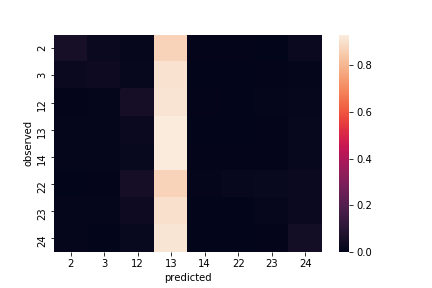

In [102]:
import seaborn as sns; sns.heatmap(validate.model_crosstab(m))